# Random forest classifier: diabetes prediction

## 1. Data acquisition

In [1]:
# Handle imports up-front

# Standard library imports
import pickle

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm, randint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Internal imports
from helper_functions.random_forest import cross_val
from helper_functions.random_forest import plot_hyperparameter_tuning
from helper_functions.random_forest import plot_cross_validation

### 1.1. Load the data

In [2]:
# Load the cleaned and processed data from the decision tree notebook
data_file='../data/processed_data/diabetes_data.pkl'

with open(data_file, 'rb') as input_data:
    training_features, testing_features, training_labels, testing_labels=pickle.load(input_data)

### 1.2. Inspect the data

In [3]:
training_features.head()

,Glucose,Insulin,BMI,Age
0,115.0,191.908591,24.0,34.0
1,142.0,190.000000,28.8,61.0
2,116.0,87.000000,22.1,37.0
3,126.0,136.054026,30.1,47.0
4,78.0,42.050901,32.5,39.0


In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Glucose  514 non-null    float64
 1   Insulin  514 non-null    float64
 2   BMI      514 non-null    float64
 3   Age      514 non-null    float64
dtypes: float64(4)
memory usage: 16.2 KB


In [5]:
training_labels.head()

0    0
1    0
2    0
3    1
4    0
Name: Outcome, dtype: int64

In [6]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


## 2. Model optimization

In [7]:
# Start a dictionary to hold optimization experiment results
hyperparameter_experiments={}

### 2.1. Baseline model performance

In [8]:
# Instantiate a random forest classifier model
model=RandomForestClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

# Collect the results
hyperparameter_experiments['Baseline']=scores * 100

Cross-validation accuracy: 75.87 +/- 1.96%


### 2.2. Hyperparameter optimization: criterion, bootstrap and class weight

In [9]:
model=RandomForestClassifier(random_state=315)

distributions={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Define the cross-validation strategy
cv_method=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

round_one_results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {round_one_results.best_params_}')

Best hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}


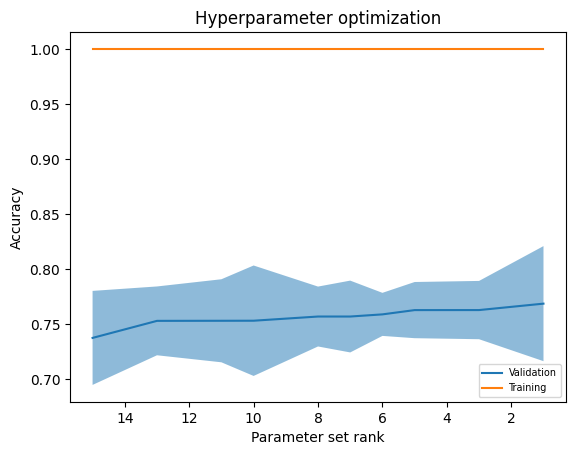

In [10]:
plot_hyperparameter_tuning(round_one_results).show()

In [11]:
# Instantiate a model using the winning parameters
model=RandomForestClassifier(
    **round_one_results.best_params_,
    random_state=315
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100
print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 76.7 +/- 5.2%


### 2.3. Other hyperparameters

In [12]:
# Instantiate a model using the winning parameters from the first round
# of hyperparameter optimization
model=RandomForestClassifier(
    **round_one_results.best_params_,
    random_state=315
)

distributions={
    'n_estimators': randint(1, 200),
    'max_depth': randint(1, 51),
    'min_samples_split': randint(2, 51),
    'min_samples_leaf': randint(1, 51),
    'min_weight_fraction_leaf': uniform(loc=0.0, scale=0.5),
    'min_impurity_decrease': uniform(loc=0.0, scale=0.5),
    'ccp_alpha': uniform(loc=0.0, scale=0.5)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=500,
    random_state=315,
    return_train_score=True
)

round_two_results=grid.fit(training_features, training_labels)
print(f'Best hyperparameters: {round_two_results.best_params_}')

Best hyperparameters: {'ccp_alpha': 0.013337545258814865, 'max_depth': 34, 'min_impurity_decrease': 0.06800302355262472, 'min_samples_leaf': 2, 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.2780688229643235, 'n_estimators': 117}


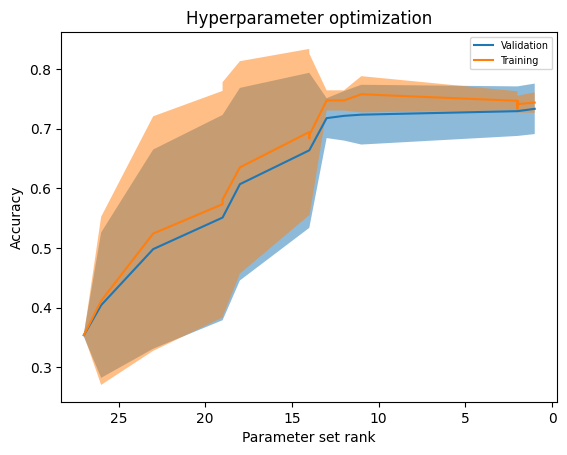

In [13]:
plot_hyperparameter_tuning(round_two_results).show()

In [14]:
# Instantiate a model using the winning parameters
model=RandomForestClassifier(
    **round_one_results.best_params_,
    **round_two_results.best_params_,
    random_state=315
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100
print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 74.3 +/- 4.2%


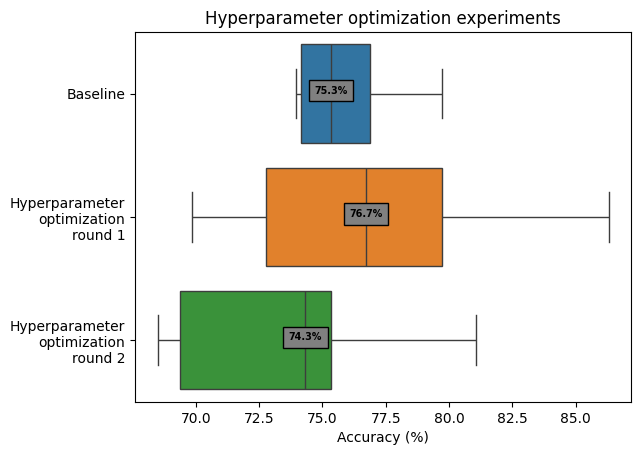

In [15]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

## 3. Model evaluation

### 3.1. Evaluate model on test data

In [16]:
# Finally, train the model on all of the training data at once
model=RandomForestClassifier(
    **round_one_results.best_params_,
    **round_two_results.best_params_,
    random_state=315
)

fit_result=model.fit(training_features, training_labels)

In [17]:
# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 71.7% accurate on the test data


### 3.2. Save model

In [21]:
# Save the model
model_output_file='../models/random_forest_diabetes_predictor.pkl'

with open(model_output_file, 'wb') as output_file:
    pickle.dump(model, output_file, protocol=pickle.HIGHEST_PROTOCOL)

## 4. A note on interpretation & some statistics

As a professional data scientist, in addition to making the model as accurate as possible, we want to have a good estimate of how accurate it will be on unseen test data. With our cross-validation results, we can take advantage of some simple statistics to talk about probabilities and confidence intervals. 

### 4.1. Confidence intervals on model performance

The first useful thing to look at is a confidence interval around the cross-validation performance:

In [18]:
lower_bound, upper_bound=norm.interval(0.95, loc=scores.mean(), scale=scores.std())
print(f'95% CI = {lower_bound*100:.1f}% - {upper_bound*100:.1f}% accuracy')

95% CI = 65.0% - 81.6% accuracy


### 4.2. Likelihood of test results

We can also use SciPy's stats module to calculate the probability of the test set result we observed, given our cross-validation results. Doing so will give us a nice way to quantify how well we are estimating true out-of-sample performance. If our test score is likely, we are in good shape. If the test result is very unlikely then something is probably wrong.

For example, if our test result is 76.0% accuracy, did we do a good job estimating out-of-sample performance with cross-validation?

In [19]:
# Use your test set accuracy here
testing_percent_accuracy=percent_accuracy

# Convert the test accuracy to a z-score using the mean and standard 
# deviation from the cross-validation
z_score=((testing_percent_accuracy/100) - scores.mean()) / scores.std()

# Use the standard normal distribution's probability density function to
# get the probability of observing our testing accuracy score
probability=norm.pdf(z_score)

print(f'Probability: {probability*100:.1f}%')

Probability: 36.9%


For example - what would happen if our test result was only 68.0% accurate - just outside our 95% confidence interval?

In [20]:
testing_percent_accuracy=68.0

z_score=((testing_percent_accuracy/100) - scores.mean()) / scores.std()
probability=norm.pdf(z_score)

print(f'Probability: {probability*100:.1f}%')

Probability: 18.0%
